In [1]:
from vae.datasets import VolSurfaceExFeatsDataSet
from vae.cond_conv_vae_with_mem import CVAEConv2DMem
import numpy as np
from torch.utils.data import DataLoader
import torch

In [2]:
torch.set_default_dtype(torch.float64)

In [3]:
linear = torch.nn.Linear(10, 20)
print(next(linear.parameters()).dtype)

torch.float64


In [4]:
dtype = torch.float32
print(dtype == torch.float64)
print(dtype == torch.float32)

False
True


In [5]:
from data_preproc.sabr_gen import SABRSurface
import matplotlib.pyplot as plt
from matplotlib import cm

In [6]:
sabr = SABRSurface()
prices, ivs = sabr.get_sim_path_sabr()
print(ivs.shape)

Generating asset price paths (SABR)
Generating implied vol


d:\Research\RL\vol-surface-vae\data_preproc\sabr_gen.py:104: RuntimeWarning: invalid value encountered in divide
  SABRIV = np.where(F == K, vol * B / (F ** (1 - self.beta)), A * B * Phi / Chi) # (num_path, num_period)


(10000, 31, 5, 5)


Text(0.5, 0.5, 'ttm')

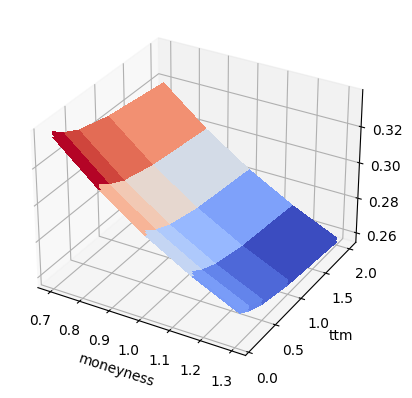

In [7]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
x = [0.7,0.85,1,1.15,1.3]
y = [0.08333,0.25,0.5,1,2]
x, y = np.meshgrid(x, y)
ax.plot_surface(x, y, ivs[0][0], cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.plot_surface(x, y, ivs[0][1], cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.plot_surface(x, y, ivs[0][2], cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel("moneyness")
ax.set_ylabel("ttm")

In [11]:
# transform to (N, seq_len, ttm_grid, moneyness_grid)
dataset = torch.from_numpy(ivs)
ex_feats = torch.from_numpy(prices).unsqueeze(-1)
seq_len = 10
N = dataset.shape[0] * (dataset.shape[1] - seq_len + 1) # total valid data points for training
ds = torch.zeros((N, 10, dataset.shape[2], dataset.shape[3]))
ex = torch.zeros((N, 10, ex_feats.shape[2]))
for i in range(dataset.shape[0]):
    for j in range(dataset.shape[1] - seq_len + 1):
        k = i * (dataset.shape[1] - seq_len + 1) + j
        ds[k, ...] = dataset[i, j:j+seq_len, ...]
        ex[k, ...] = ex_feats[i, j:j+seq_len, ...]
print(ds.shape)
print(ex.shape)

torch.Size([220000, 10, 5, 5])
torch.Size([220000, 10, 1])


In [14]:
print(ds[0][0])

tensor([[0.3385, 0.3173, 0.3000, 0.2856, 0.2738],
        [0.3338, 0.3130, 0.2959, 0.2817, 0.2700],
        [0.3292, 0.3086, 0.2917, 0.2778, 0.2662],
        [0.3245, 0.3042, 0.2876, 0.2738, 0.2624],
        [0.3199, 0.2999, 0.2835, 0.2699, 0.2587]])


In [16]:
np.lib.stride_tricks.sliding_window_view(ivs, seq_len, axis=1).shape

(10000, 22, 5, 5, 10)

In [18]:
test = np.lib.stride_tricks.sliding_window_view(ivs, seq_len, axis=1).transpose([0, 1, 4, 2, 3]).reshape((-1, seq_len, ivs.shape[2], ivs.shape[3]))
test = torch.from_numpy(test)
print(test.shape)
print(test[0][0])

torch.Size([220000, 10, 5, 5])
tensor([[0.3385, 0.3173, 0.3000, 0.2856, 0.2738],
        [0.3338, 0.3130, 0.2959, 0.2817, 0.2700],
        [0.3292, 0.3086, 0.2917, 0.2778, 0.2662],
        [0.3245, 0.3042, 0.2876, 0.2738, 0.2624],
        [0.3199, 0.2999, 0.2835, 0.2699, 0.2587]])


In [20]:
print(torch.all(test == ds))

tensor(True)


In [25]:
price_test = np.lib.stride_tricks.sliding_window_view(prices, seq_len, axis=1).reshape((-1, seq_len, 1))
price_test = torch.from_numpy(price_test)
print(price_test.shape)
print(torch.all(price_test == ex))

torch.Size([220000, 10, 1])
tensor(True)


In [30]:
print(test[0][2])

tensor([[0.3374, 0.3163, 0.2989, 0.2845, 0.2727],
        [0.3328, 0.3119, 0.2948, 0.2806, 0.2689],
        [0.3282, 0.3076, 0.2907, 0.2767, 0.2652],
        [0.3235, 0.3033, 0.2866, 0.2728, 0.2615],
        [0.3189, 0.2989, 0.2825, 0.2689, 0.2577]])


In [27]:
print(price_test[0])

tensor([[10.0000],
        [10.0877],
        [ 9.8635],
        [10.1314],
        [10.0720],
        [ 9.9372],
        [10.1005],
        [10.2580],
        [10.1416],
        [10.1428]])


In [28]:
print(price_test[10])

tensor([[ 9.7472],
        [ 9.9532],
        [10.1308],
        [10.3021],
        [ 9.9457],
        [ 9.8859],
        [ 9.8849],
        [ 9.9502],
        [ 9.9963],
        [10.2146]])


In [31]:
print(test[10][2])

tensor([[0.3204, 0.2993, 0.2819, 0.2676, 0.2558],
        [0.3163, 0.2954, 0.2783, 0.2641, 0.2525],
        [0.3122, 0.2916, 0.2747, 0.2607, 0.2492],
        [0.3081, 0.2878, 0.2711, 0.2573, 0.2459],
        [0.3040, 0.2839, 0.2675, 0.2539, 0.2427]])


In [35]:
price2 = prices.reshape((prices.shape[0], prices.shape[1], 1))
print(price2.shape)
price_test = np.lib.stride_tricks.sliding_window_view(price2, seq_len, axis=1).transpose([0, 1, 3, 2]).reshape((-1, seq_len, 1))
price_test = torch.from_numpy(price_test)
print(price_test.shape)
print(torch.all(price_test == ex))

(10000, 31, 1)
torch.Size([220000, 10, 1])
tensor(True)
